In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [2]:
url = 'https://www.ebay.com/sch/i.html?_nkw=laptop' 

response = requests.get(url)
response

<Response [200]>

In [ ]:
soup = BeautifulSoup(response.text, 'html.parser')

# find element which contains product information
items = soup.find_all('li', class_='s-item')
items

[<li class="s-item s-item__pl-on-bottom" data-marko-key="0 s0-55-0-9-8-4-4-0-2-1[0]" data-view="mi:1686|iid:1" data-viewport='{"trackableId":"01GDF2P4GS7EBZ8M2AWN707B"}' id=""><div class="s-item__wrapper clearfix"><!--F#f_0--><div class="s-item__image-section"><div class="s-item__image"><a _sp="" aria-hidden="true" data-carousel-tabindex="-1" data-interactions='[{"actionKind":"NAVSRC","interaction":"wwFVrK2vRE0lhQY0MREUzME5KNVY2VE1XNkJEMTUAAAg3NDAwDE5BVlNSQwA="}]' data-s-81m5334='{"eventFamily":"LST","eventAction":"ACTN","actionKind":"NAVSRC","actionKinds":["NAVSRC"],"operationId":"","flushImmediately":false,"eventProperty":{"trackableId":"01GDF2P4GS7EBZ8M2AWN707B","interaction":"wwFVrK2vRE0lhQY0MREUzME5KNVY2VE1XNkJEMTUAAAg3NDAwDE5BVlNSQwA="}}' href="https://ebay.com/itm/123456?itmmeta=012DEW30YG0MEEKND7NH&amp;hash=item123546:g:acwAA9KNiJowH:sc:ShippingMethodStandard!95008!US!-1&amp;itmprp=enc%3AbgepL1tlUHjMGCVfSTGJh%2BzsVKeJ3CQk7NizDI4BZeppuFnmyS6Ijyp8lh%2FnEw%2BWqO7uTV1Q6izE1R0T54aV8

In [20]:
data = []

for item in items:
    title = item.find(['h3', 'div'], class_='s-item__title')
    price = item.find('span', class_='s-item__price')
    shipping = item.find('span', class_='s-item__shipping')
    location = item.find('span', class_='s-item__location')
    quantity = item.find('span', class_='s-item__dynamic s-item__quantitySold')

    if title and title.get_text() == "Shop on eBay":
        continue

    data.append({
        'Title': title.get_text() if title else 'N/A',
        'Price': price.get_text() if price else 'N/A',
        'Shipping': shipping.get_text() if shipping else 'N/A',
        'Location': location.get_text() if location else 'N/A',
        'Quantity Sold': quantity.get_text() if quantity else 'N/A',
    })

df = pd.DataFrame(data)

In [21]:
df.head()
df.tail()

,Title,Price,Shipping,Location,Quantity Sold
78,"Lenovo IdeaPad Laptop Computer 15.6"" Intel Dua...","IDR4,632,516.00","+IDR1,303,580.04 delivery",from United States,20 sold
79,Microsoft Surface Pro 7+ Intel i5 1135G7 2.40G...,"IDR4,189,707.24","+IDR518,423.37 delivery",from Australia,N/A
80,"14"" TouchScreen Dell Latitude Laptop PC: Intel...","IDR4,947,161.80","+IDR1,021,976.20 delivery",from United States,N/A
81,"HP EliteBook 745 G5 14” Laptop, AMD Ryzen 7 Pr...","IDR3,322,460.40","+IDR1,063,652.24 delivery",from United States,9 sold
82,"Dell Precision 15.6"" Touchscreen Laptop Core i...","IDR4,638,161.36","+IDR1,199,971.08 delivery",from United States,510 sold


In [ ]:
# DATA REPROCESSING

# 1. change price and shipping to float
def clean_currency(val):
    try:
        return float(val.replace('IDR', '').replace(',', '').strip())
    except:
        return None

df['Price_clean'] = df['Price'].apply(clean_currency)
df['Shipping_clean'] = df['Shipping'].str.extract(r'(\d[\d,\.]*)')[0].apply(clean_currency)

# 2. change quantity sold to numeric
import re
def clean_quantity(val):
    if pd.isna(val) or val == 'N/A':
        return 0
    val = re.findall(r'[\d,]+', val)
    if val:
        return int(val[0].replace(',', ''))
    return 0

df['Quantity_clean'] = df['Quantity Sold'].apply(clean_quantity)

# 3. clean location column
df['Country'] = df['Location'].str.replace('from ', '').str.strip()

In [ ]:
df_clean = df[['Title', 'Price_clean', 'Shipping_clean', 'Quantity_clean', 'Country']]
df_clean

,Title,Price_clean,Shipping_clean,Quantity_clean,Country
0,"HP ELITEBOOK 840 G6 14"" Intel Core i5-8365U 1....",2116843.96,929990.04,200,United States
1,Dell Latitude Laptop Light Gaming PC Core i7 1...,4969411.16,1117117.12,1810,United States
2,"Dell Latitude 5420 Laptop 14"" Windows 11 Intel...",3486673.96,974488.76,1596,United States
3,"HP ELITEBOOK 840 G6 14"" Intel Core i5-8365U 1....",2116843.96,929990.04,171,United States
4,Dynabook PORTEGE X30W-J Intel i5 1135G7 2.40GH...,4221447.45,518423.37,123,Australia
...,...,...,...,...,...
78,"Lenovo IdeaPad Laptop Computer 15.6"" Intel Dua...",4632516.00,1303580.04,20,United States
79,Microsoft Surface Pro 7+ Intel i5 1135G7 2.40G...,4189707.24,518423.37,0,Australia
80,"14"" TouchScreen Dell Latitude Laptop PC: Intel...",4947161.80,1021976.20,0,United States
81,"HP EliteBook 745 G5 14” Laptop, AMD Ryzen 7 Pr...",3322460.40,1063652.24,9,United States


In [9]:
df_clean['Country'].unique()

array(['United States', 'Australia', 'N/A', 'United Kingdom', 'Germany'],
      dtype=object)

In [10]:
df_clean['Country'] = df_clean['Country'].replace('N/A', np.nan)

C:\Users\acer\AppData\Local\Temp\ipykernel_19044\3799564906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Country'] = df_clean['Country'].replace('N/A', np.nan)


In [11]:
df_clean.isna().sum()

Title             0
Price_clean       7
Shipping_clean    0
Quantity_clean    0
Country           8
dtype: int64

In [12]:
df_clean = df_clean.dropna(subset=['Price_clean'])
df_clean = df_clean.dropna(subset=['Country'])
df_clean.isna().sum()

Title             0
Price_clean       0
Shipping_clean    0
Quantity_clean    0
Country           0
dtype: int64

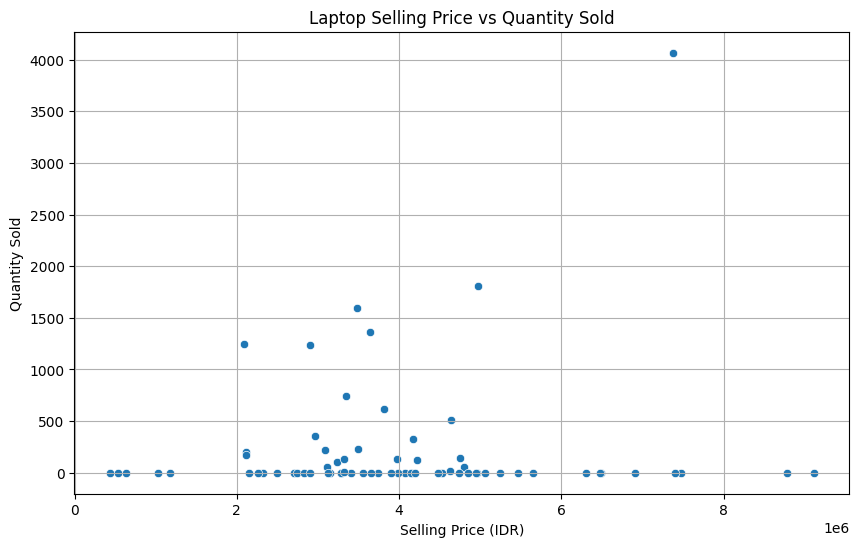

In [24]:
# scatterplot of price vs quantity sold
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='Price_clean', y='Quantity_clean')
plt.title('Laptop Selling Price vs Quantity Sold')
plt.xlabel('Selling Price (IDR)')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.show()

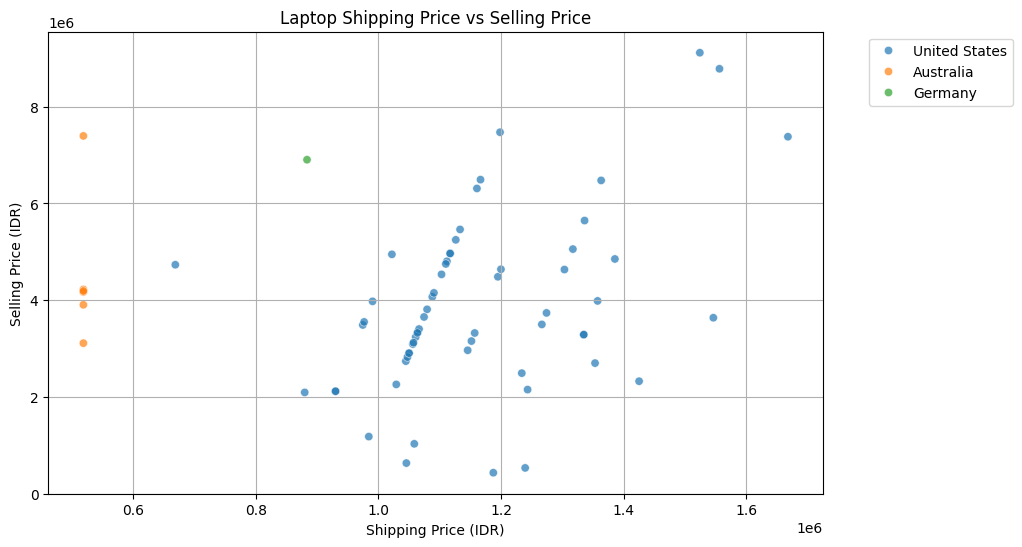

In [25]:
# scatterplot shipping vs price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='Shipping_clean', y='Price_clean', hue='Country', alpha=0.7)
plt.title('Laptop Shipping Price vs Selling Price')
plt.xlabel('Shipping Price (IDR)')
plt.ylabel('Selling Price (IDR)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

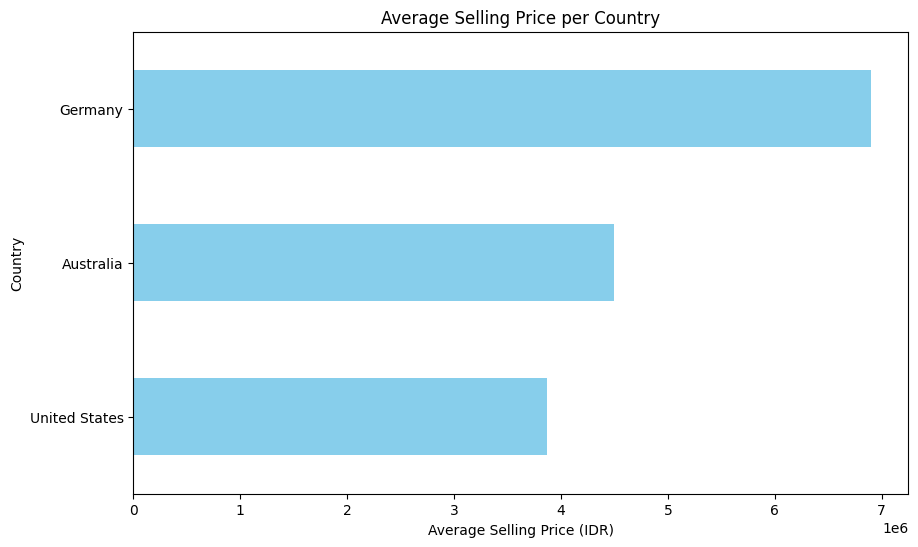

In [26]:
# average selling price per country
avg_price_per_country = df_clean.groupby('Country')['Price_clean'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_price_per_country.plot(kind='barh', color='skyblue')
plt.xlabel('Average Selling Price (IDR)')
plt.title('Average Selling Price per Country')
plt.show()

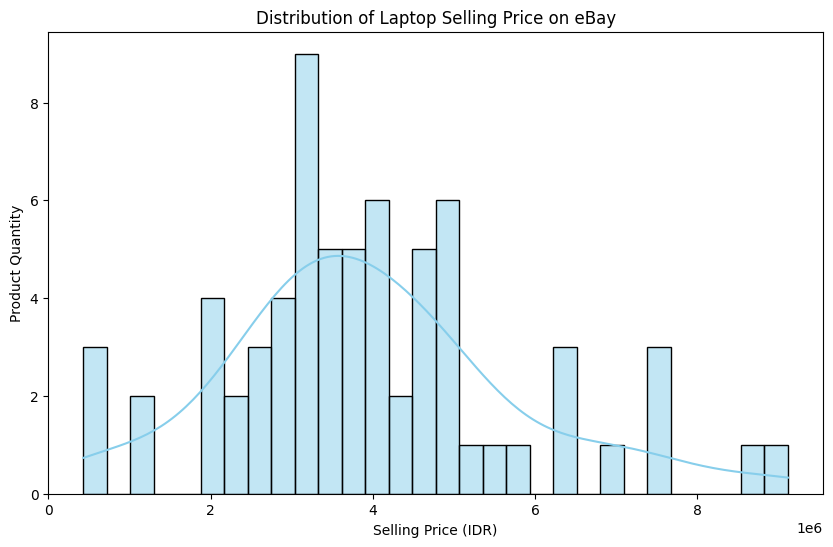

In [27]:
# selling price distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Price_clean'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Laptop Selling Price on eBay')
plt.xlabel('Selling Price (IDR)')
plt.ylabel('Product Quantity')
plt.show()

C:\Users\acer\AppData\Local\Temp\ipykernel_19044\2911229760.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_sold, x='Quantity_clean', y='Title', palette='viridis')


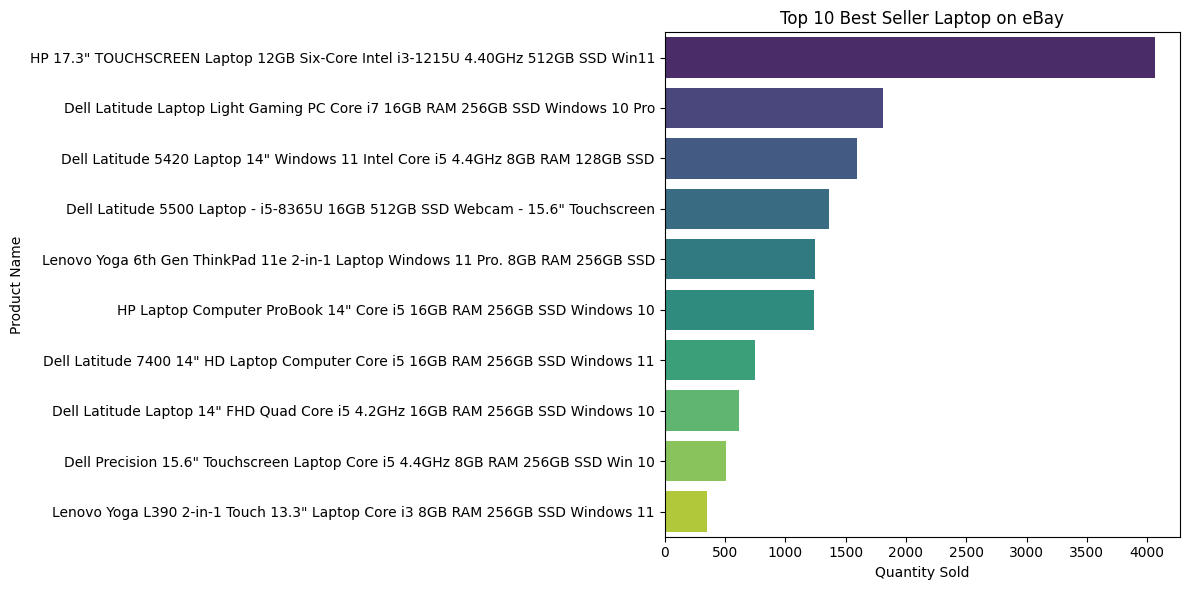

In [28]:
# top 10 best seller laptop

top_sold = df_clean.sort_values(by='Quantity_clean', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_sold, x='Quantity_clean', y='Title', palette='viridis')
plt.title('Top 10 Best Seller Laptop on eBay')
plt.xlabel('Quantity Sold')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

C:\Users\acer\AppData\Local\Temp\ipykernel_19044\2786932020.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='Country', y='Price_clean', palette='Set2')


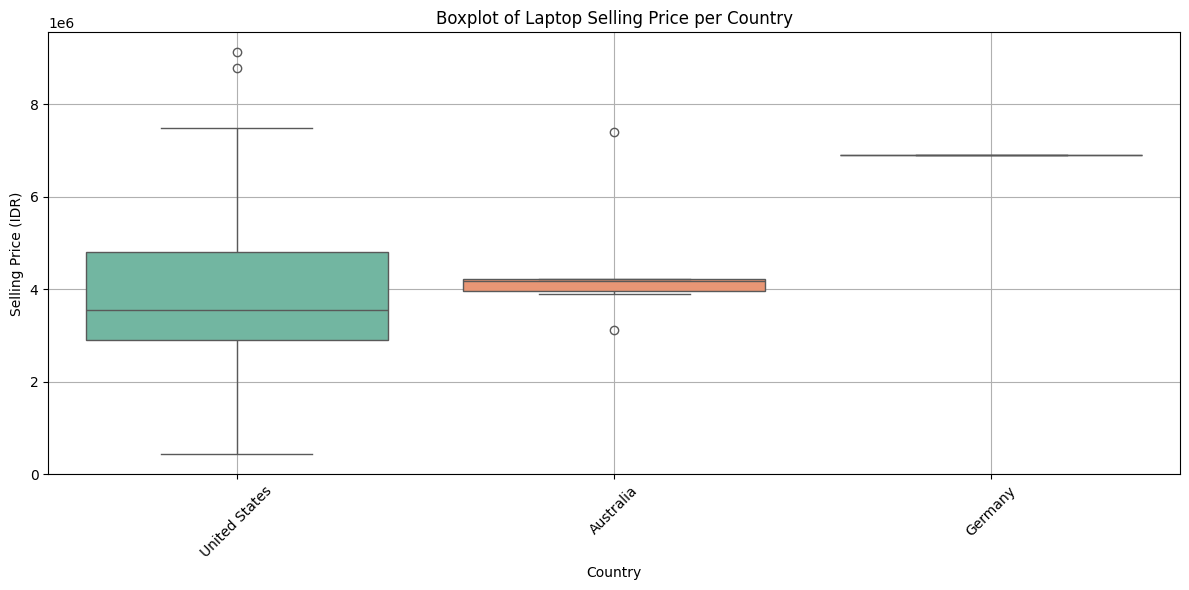

In [29]:
# boxplot of laptop selling price per country

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean, x='Country', y='Price_clean', palette='Set2')
plt.title('Boxplot of Laptop Selling Price per Country')
plt.xlabel('Country')
plt.ylabel('Selling Price (IDR)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()